In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('pfcn.npz.npz')
list(data)

['train_images', 'test_images', 'train_mattes', 'test_mattes']

In [2]:
train_images, test_images, train_mattes, test_mattes = data[list(data)[0]], data[list(data)[1]], data[list(data)[2]], data[list(data)[3]]

In [3]:
# 컬로와 흑백
np.shape(train_images), np.shape(train_mattes), train_mattes.min(), train_mattes.max()

((1700, 100, 75, 3), (1700, 100, 75), 0.0, 1.0)

In [4]:
train_mattes_reshape = np.reshape(train_mattes, (1700, 100, 75, 1))
test_mattes_reshape = np.reshape(test_mattes, (300, 100, 75, 1))

Text(0.5, 1.0, 'result(X*Y), back black fill')

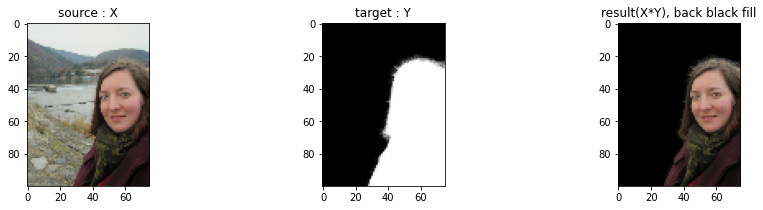

In [5]:
plt.figure(figsize = (15,3))
plt.subplot(1, 3, 1)
plt.imshow(train_images[2])
plt.title('source : X')

plt.subplot(1, 3, 2)
plt.imshow(train_mattes[2], cmap='gray')
plt.title('target : Y')

plt.subplot(1, 3, 3)
plt.imshow(train_mattes_reshape[2] * train_images[2]) 
plt.title('result(X*Y), back black fill')

### 오토인코더 제작

In [6]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, UpSampling2D, Flatten, Reshape
from keras.models import Model

def ae_like():
    inputs = Input((100, 75, 3))
    x = Conv2D(32, 3, 2, activation='relu', padding='same')(inputs)
    x = Conv2D(64, 3, 2, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, 2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    latent = Dense(10)(x)

    x = Dense((13 * 10 * 128))(latent)
    x = Reshape((13, 10, 128))(x)

    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(128, (2,2), (1,1), activation='relu', padding='valid')(x)

    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(64, (1,1), (1,1), activation='relu', padding='valid')(x)

    x = UpSampling2D(size = (2,2))(x)
    x = Conv2D(32, (1,2), (1,1), activation='relu', padding='valid')(x)

    x = Conv2D(1, (1,1), (1,1), activation='sigmoid')(x)


    model = Model(inputs, x)
    return model


In [7]:
model = ae_like()
model.compile(loss="mse",
             optimizer = "adam",
             metrics = ['accuracy'])

hist = model.fit(train_images, train_mattes, 
                 validation_data = (test_images, test_mattes),
                epochs = 20)

Epoch 1/20
54/54 [==============================] - 5s 26ms/step - loss: 0.1408 - accuracy: 0.7479 - val_loss: 0.1253 - val_accuracy: 0.7626
Epoch 2/20
54/54 [==============================] - 1s 16ms/step - loss: 0.1258 - accuracy: 0.7643 - val_loss: 0.1209 - val_accuracy: 0.7688
Epoch 3/20
54/54 [==============================] - 1s 16ms/step - loss: 0.1185 - accuracy: 0.7720 - val_loss: 0.1095 - val_accuracy: 0.7810
Epoch 4/20
54/54 [==============================] - 1s 16ms/step - loss: 0.0975 - accuracy: 0.8016 - val_loss: 0.0877 - val_accuracy: 0.8128
Epoch 5/20
54/54 [==============================] - 1s 16ms/step - loss: 0.0806 - accuracy: 0.8245 - val_loss: 0.0820 - val_accuracy: 0.8193
Epoch 6/20
54/54 [==============================] - 1s 16ms/step - loss: 0.0708 - accuracy: 0.8376 - val_loss: 0.0745 - val_accuracy: 0.8295
Epoch 7/20
54/54 [==============================] - 1s 16ms/step - loss: 0.0612 - accuracy: 0.8502 - val_loss: 0.0702 - val_accuracy: 0.8360
Epoch 8/20
54

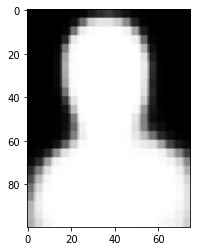

In [8]:
result = model.predict(test_images[:1])
np.shape(result)
plt.imshow(result[0], cmap = 'gray')

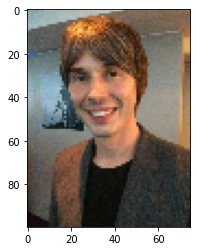

In [9]:
plt.imshow(test_images[0])

Text(0.5, 1.0, 'result(X*Y_hat), back black fill')

<Figure size 1080x216 with 0 Axes>

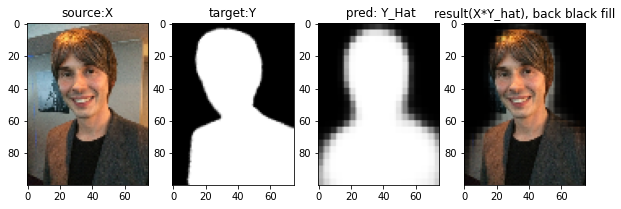

In [10]:
plt.figure(figsize=(15,3))
result=model.predict(test_images[:1])
plt.figure(figsize=(10,3))
plt.subplot(1,4,1)
plt.imshow(test_images[0])
plt.title('source:X')

plt.subplot(1,4,2)
plt.imshow(test_mattes[0],cmap='gray')
plt.title('target:Y')

plt.subplot(1,4,3)
plt.imshow(result[0] ,cmap='gray')
plt.title(' pred: Y_Hat')

plt.subplot(1,4,4)
plt.imshow(test_images[0]*result[0])
plt.title('result(X*Y_hat), back black fill')


In [13]:
result[result>0.4] = 1

Text(0.5, 1.0, ' pred: Y_Hat')

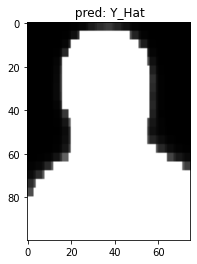

In [14]:
plt.imshow(result[0] ,cmap='gray')
plt.title(' pred: Y_Hat')

### U-net

In [16]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, MaxPool2D, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet_like():
    inputs = Input((100, 75, 3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D((2,2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D((2,2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D((2,2))(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D((2,2))(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(1, (1,1), activation="sigmoid")(c9)

    model = Model(inputs, outputs)
    return model

# unet_like() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model_unet = unet_like()
model_unet.summary()

model_unet.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
hist = model_unet.fit(train_images, train_mattes, validation_data=(test_images, test_mattes_reshape), epochs=20)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 100, 75, 16)  448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
____________________________________________________________________________________________

Epoch 1/20
54/54 [==============================] - 6s 64ms/step - loss: 0.1279 - accuracy: 0.7597 - val_loss: 0.1368 - val_accuracy: 0.7570
Epoch 2/20
54/54 [==============================] - 2s 40ms/step - loss: 0.0637 - accuracy: 0.8499 - val_loss: 0.1281 - val_accuracy: 0.7651
Epoch 3/20
54/54 [==============================] - 2s 40ms/step - loss: 0.0507 - accuracy: 0.8627 - val_loss: 0.1030 - val_accuracy: 0.7963
Epoch 4/20
54/54 [==============================] - 2s 40ms/step - loss: 0.0428 - accuracy: 0.8708 - val_loss: 0.1007 - val_accuracy: 0.8037
Epoch 5/20
54/54 [==============================] - 2s 40ms/step - loss: 0.0366 - accuracy: 0.8771 - val_loss: 0.1499 - val_accuracy: 0.7496
Epoch 6/20
54/54 [==============================] - 2s 40ms/step - loss: 0.0357 - accuracy: 0.8771 - val_loss: 0.0939 - val_accuracy: 0.8144
Epoch 7/20
54/54 [==============================] - 2s 40ms/step - loss: 0.0355 - accuracy: 0.8771 - val_loss: 0.1030 - val_accuracy: 0.8087
Epoch 8/20
54

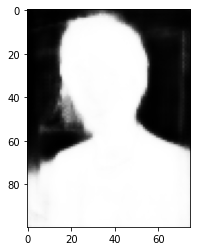

In [17]:
result_unet = model_unet.predict(test_images[:1])
np.shape(result_unet)
plt.imshow(result_unet[0], cmap = 'gray')

Text(0.5, 1.0, 'result(X*Y_hat), back black fill')

<Figure size 1080x216 with 0 Axes>

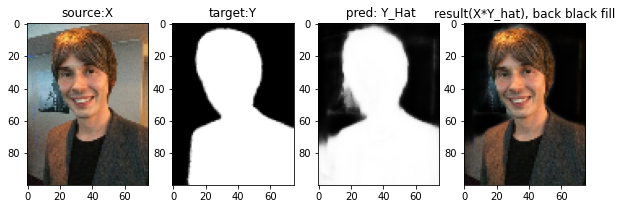

In [19]:
plt.figure(figsize=(15,3))
result=model_unet.predict(test_images[:1])
plt.figure(figsize=(10,3))
plt.subplot(1,4,1)
plt.imshow(test_images[0])
plt.title('source:X')

plt.subplot(1,4,2)
plt.imshow(test_mattes[0],cmap='gray')
plt.title('target:Y')

plt.subplot(1,4,3)
plt.imshow(result[0] ,cmap='gray')
plt.title(' pred: Y_Hat')

plt.subplot(1,4,4)
plt.imshow(test_images[0]*result[0])
plt.title('result(X*Y_hat), back black fill')
